In [1]:
import os
import sys
import tqdm
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

base_dir = os.path.dirname(os.getcwd())
sys.path.append(base_dir)

from src.likelihoods import GaussianBagLikelihood
from src.models import VariationalGP

### Engineer Toy Bag Dataset

In [2]:
def generate_toy_1d_dataset(seed, n_bags):
    # Set random seed for reproducibility
    np.random.seed(seed)
    n_bags = n_bags + 1
    
    # Define latent groundtruth mapping
    x = np.linspace(0, 1, 1000)
    y = 4 * np.cos(x * np.pi)
    
    # Split individuals inputs and observations into bags based on targets ranges
    ranges_delimiters = np.linspace(-4, 4, n_bags)
    bags_masks = [(y > amin) & (y < amax) for (amin, amax) in zip(ranges_delimiters[:-1], ranges_delimiters[1:])]
    bags = [torch.from_numpy(x[mask]) for mask in bags_masks]
    individual_targets = [torch.from_numpy(y[mask]) for mask in bags_masks]
    
    # Aggregate individual observation and add some noise
    aggregated_bags_targets = torch.Tensor([y[mask].mean() for mask in bags_masks])
    eps = np.sqrt(0.04) * torch.randn_like(aggregated_bags_targets)
    aggregated_bags_targets = aggregated_bags_targets + eps
    return bags, aggregated_bags_targets, individual_targets

bags, bags_targets, individual_targets = generate_toy_1d_dataset(seed=5, n_bags=3)
bags_sizes = torch.IntTensor(list(map(len, bags)))
stacked_bags = torch.cat(bags).float()

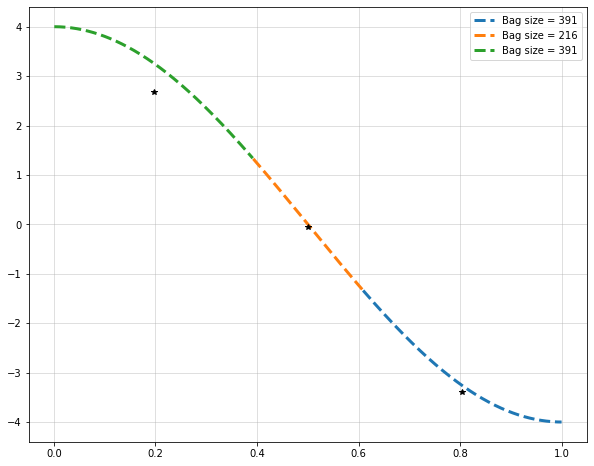

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for bag, individiual_targets, bag_target in zip(bags, individual_targets, bags_targets):
    ax.plot(bag.numpy(), individiual_targets.numpy(), linewidth=3, linestyle='--', label=f"Bag size = {len(bag)}")
    ax.plot(bag.mean().numpy(), bag_target.item(), 'k*')
ax.grid(alpha=0.5)
plt.legend()
plt.show()

### Estimating individuals distribution from aggregated targets with a variational GP

- __Likelihood $p(\mathbf{y}|B)$__

Dataset $\mathcal{D} = \{(B_a, y_a)\}_{a=1}^n$ where $B_a = \{x_i^a\}_{i=1}^{N_a}$


$$
y^a_i|x^a_i\sim\mathcal{N}(\mu(x_i^a), \sigma^2)
$$

$$
y^a|B_a \sim\frac{1}{N_a}\sum_{i=1}^{N_a}y^a_i|x^a_i\sim\mathcal{N}\left(\mu^a, \frac{\sigma^2}{N_a}\right)\qquad\mu^a=\frac{1}{N_a}\sum_{i=1}^{N_a}\mu(x_i^a)
$$

And assuming independence given bags, if $\mathbf{y}=[y^1\ldots y^n]^\top$ and $B = \{B_a\}_{a=1}^{n}$, we have

$$
\mathbf{y}|B\sim\mathcal{N}(\underline{\mu}, \Sigma)\qquad\underline{\mu} = [\mu^1,\ldots,\mu^n]^\top\qquad\Sigma=\operatorname{Diag}\left(\frac{\sigma^2}{N_1},\ldots,\frac{\sigma^2}{N_n}\right)
$$

- __Expected logprobability $\mathbb{E}_q[\log p(\mathbf{y}|B)]$__

With the same notations as above

$$
\mathbb{E}_q[\log p(\mathbf{y}|B)] = -\frac{1}{2}\sum_{a=1}^n \frac{N_a}{\sigma^2}\left((y^a)^2 - \frac{2y^a\mathbf{1}^\top\mathbf{m}^a}{N_a} + \frac{\mathbf{1}^\top\left(\mathbf{S}^a + \mathbf{m}^a(\mathbf{m}^a)^\top\right)\mathbf{1}}{N_a^2}\right) - \frac{1}{2}\sum_{a=1}^n\log\left(2\pi\frac{\sigma^2}{N_a}\right)
$$


where $q(\underline{\mu}^a) \sim\mathcal{N}(\mathbf{m}^a, \mathbf{S}^a)$


- __Build GP Model__

We put a GP prior on the likelihood mean parameter $\mu\sim\operatorname{GP}(m, k)$ and adopt a variational optimization strategy to approximate posterior with gaussian variational distribution on inducing points $\mathbf{u}$ as $p(\mathbf{u}|\mathbf{y})\approx q(\mathbf{u})\sim\mathcal{N}(\eta_\mathbf{u}, \Sigma_\mathbf{u})$

The approximate posterior distribution on bag individuals is given by $p(\mu|y^a)\approx q(\mu) = \mathcal{N}(\mu; \mathbf{m}^a, \mathbf{S}^a)$ where

$$
\mathbf{m}^a = m(B_a) + \mathbf{K}_{B_a W}\mathbf{K}^{-1}_{WW}(\eta_\mathbf{u} - m(W))
$$

$$
\mathbf{S}^a = \mathbf{K}_{B_aB_a} - \mathbf{K}_{B_a W}(\mathbf{K}_{WW}^{-1}-\mathbf{K}_{WW}^{-1}\Sigma_\mathbf{u}\mathbf{K}_{WW}^{-1})\mathbf{K}_{WB_a}
$$

In [4]:
landmark_points = torch.linspace(0, 1, 50).float()

model = VariationalGP(landmark_points=landmark_points,
                      mean_module=gpytorch.means.ConstantMean(),
                      covar_module=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()))

likelihood = GaussianBagLikelihood()

elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(stacked_bags))

### Learn variational distribution

In [5]:
epochs = 100

model.train()
likelihood.train()

parameters = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params=parameters, lr=0.01)


epoch_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
for epoch in epoch_iter:
    optimizer.zero_grad()
    variational_posterior_distribution = model(stacked_bags)
    loss = -elbo(variational_posterior_distribution, bags_targets, bags_sizes=bags_sizes)
    epoch_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

### Visualize predicted posterior

In [6]:
def predict_posterior(individuals, model, likelihood, bags_sizes):
    # Get into evaluation mode
    model.eval()
    likelihood.eval()
    # Compute posterior distribution on new inputs
    with torch.no_grad():
        posterior_dist_individual_samples = model(individuals)
        marginal_distribution_new_observation = likelihood(posterior_dist_individual_samples, bags_sizes)
    return marginal_distribution_new_observation

def plot_posterior(posterior_distribution, individuals, individuals_targets):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    lower, upper = posterior_distribution.confidence_region()
    ax.plot(individuals.numpy(), individuals_targets.numpy(), '--', linewidth=1, color='tomato', label='Groundtruth')
    ax.plot(individuals.numpy(), posterior_distribution.mean.numpy(), 'firebrick', label='Mean Prediction')
    ax.fill_between(x=individuals.numpy(), y1=lower.numpy(), y2=upper.numpy(), color='tomato', alpha=0.3, label='Confidence')
    ax.grid(alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
# Stack all individuals from bags together and reorder - have been disordered when splitting bags
stacked_individuals = torch.cat(bags).float().sort()
stacked_individuals_targets = torch.cat(individual_targets).float()[stacked_individuals.indices]
stacked_individuals = stacked_individuals.values

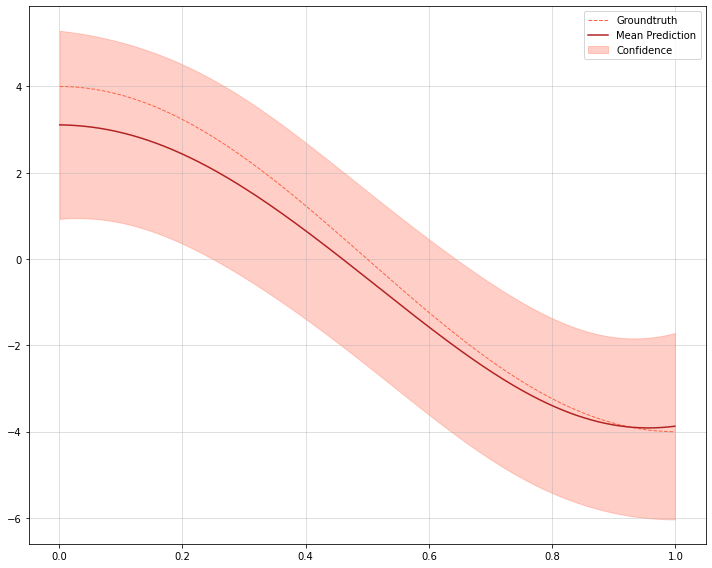

In [8]:
posterior_dist_individual_samples = predict_posterior(individuals=stacked_individuals,
                                                      model=model,
                                                      likelihood=likelihood,
                                                      bags_sizes=bags_sizes)

plot_posterior(posterior_distribution=posterior_dist_individual_samples,
               individuals=stacked_individuals,
               individuals_targets=stacked_individuals_targets)

---